<a href="https://colab.research.google.com/github/AbiramiMuthu/TensorFlow-TimeSeries-MultiStepPrediction-LSTM-Power_Consumption/blob/main/TF_TimeSeries_Multi_Step_LSTM_Household_Power_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read the dataset

In [5]:
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Household_Electric_Power_Consumption/household_power_consumption.txt",sep=';',
                 parse_dates=True,low_memory=False)

In [6]:
data.head(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
# Join the Date and Time as single column and set that column as index

data["DateTime"]=data["Date"].str.cat(data["Time"],sep=' ')
data.drop(["Date","Time"],axis=1,inplace=True)
data.set_index(["DateTime"],inplace=True)

In [8]:
data.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
16/12/2006 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
16/12/2006 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
16/12/2006 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
16/12/2006 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [10]:
# Check null values
data.isna().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [11]:
data.replace('?',nan,inplace=True)

In [12]:
data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [13]:
## Convert the object columns to float
data=data.astype(float)

## Filling the Missing Values

In [14]:
## replace the na values with the previous value in the column
# the date time shows the reading for every minute in a day so 24*60 =1440
def FillNan(data):
  oneday=24*60
  for row in range(data.shape[0]):
    for col in range(data.shape[1]):
      if np.isnan(data[row,col]):
        data[row,col]=data[row-oneday,col]

In [15]:
FillNan(data.values)

In [16]:
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [17]:
data.shape

(2075259, 7)

In [18]:
# Store the cleaned file and read again
data.to_csv("CleanedFile.csv")

## Read the Cleaned File

In [19]:
dataset=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Household_Electric_Power_Consumption/CleanedFile.csv",
                    parse_dates=True,index_col="DateTime",low_memory=False)


In [20]:
dataset.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [21]:
dataset.tail(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [23]:
# combine all the minutes of a day to a single day entry, all the coulmn values of the minutes will be summedup
data=dataset.resample('D').sum()
data.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0


## Exploratory Data Analysis

### Plotting each Features

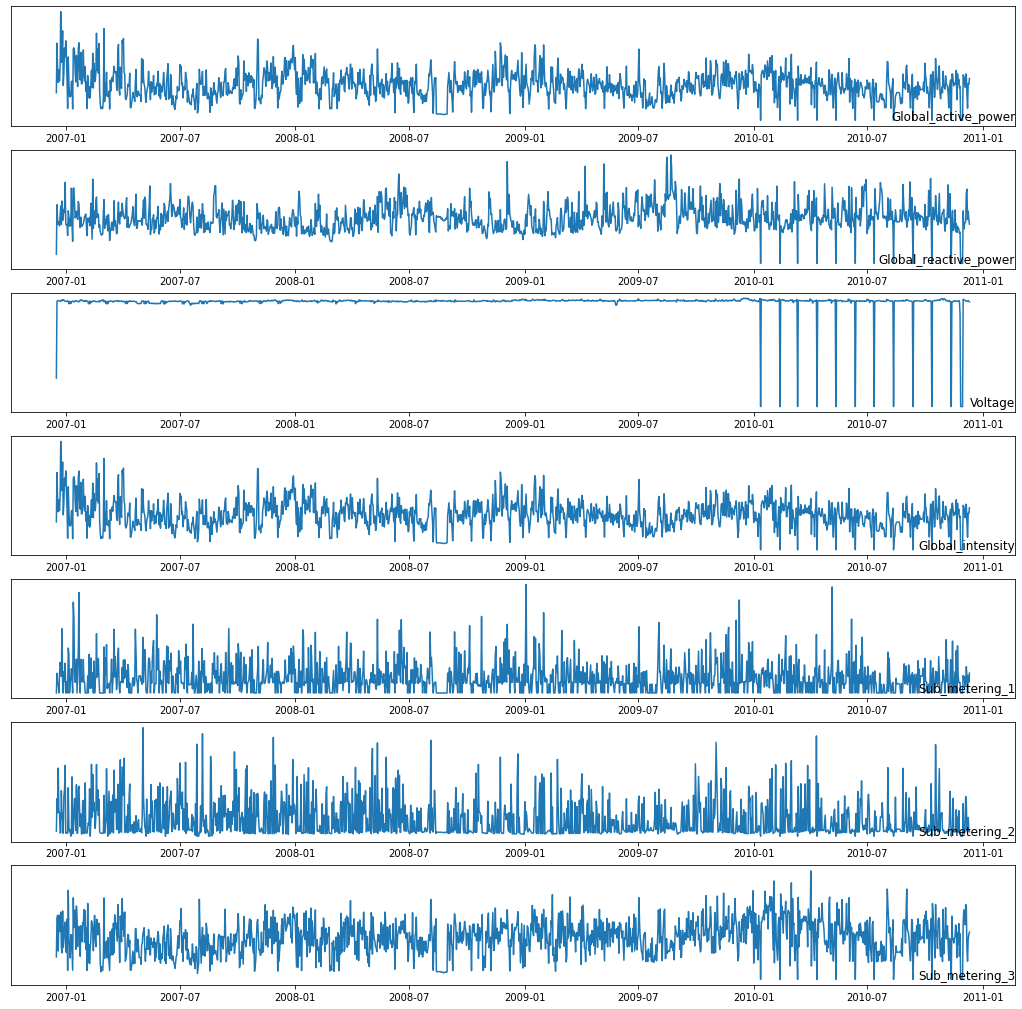

In [80]:
fig,ax=plt.subplots(figsize=(18,18))

for i in range(len(data.columns)):
  #no.ofrows,cols,number
  plt.subplot(len(data.columns),1,i+1)
  name=data.columns[i]
  plt.plot(data[name])
  plt.title(name,y=0,loc='right')
  plt.yticks([])
plt.show()
fig.tight_layout()

### Exploring Global active power for every year

In [82]:
years=['2007','2008','2009','2010']

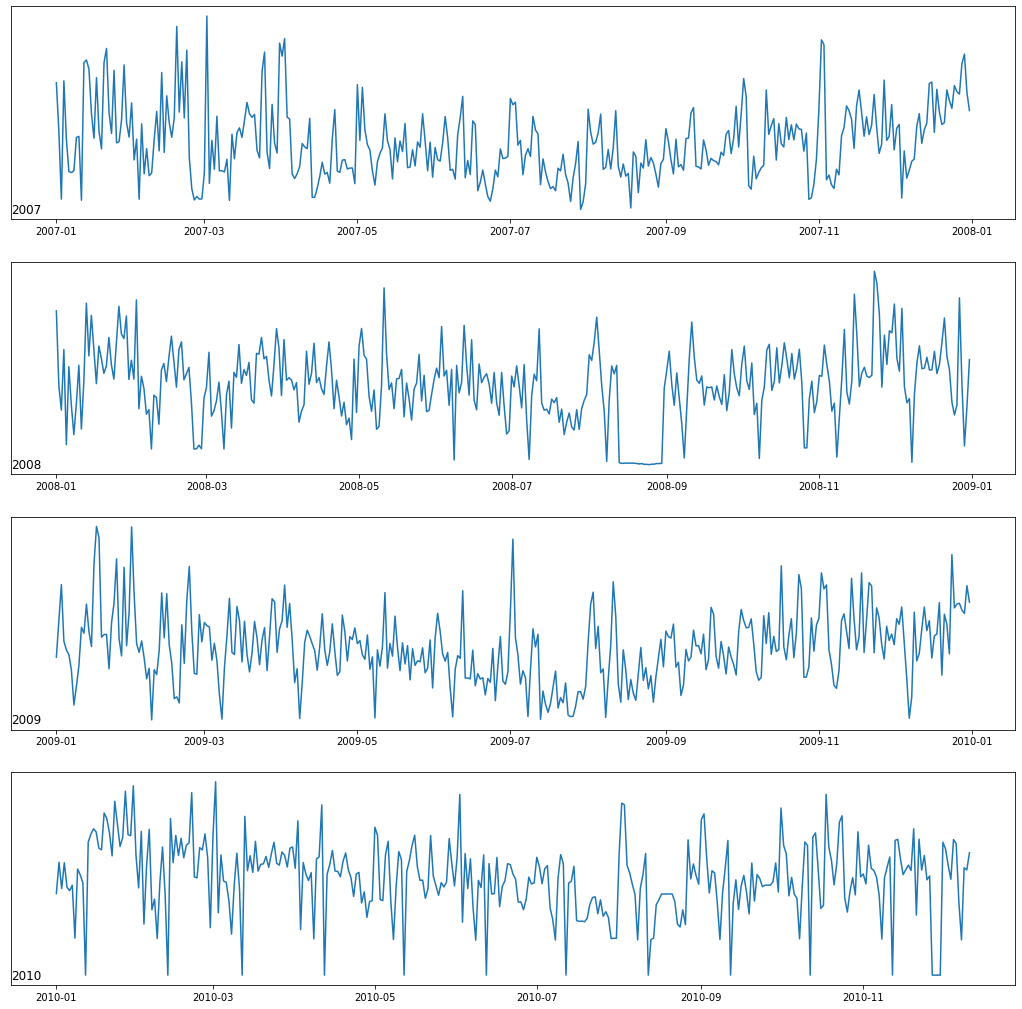

In [83]:
fig,ax=plt.subplots(figsize=(18,18))

for i in range(len(years)):
  #no.ofrows,cols,number
  plt.subplot(len(years),1,i+1)
  year=years[i]
  plt.plot(data[str(year)]['Global_active_power'])
  plt.title(str(year),y=0,loc='left')
  plt.yticks([])
plt.show()
fig.tight_layout()

## Power Consumption in Histogram

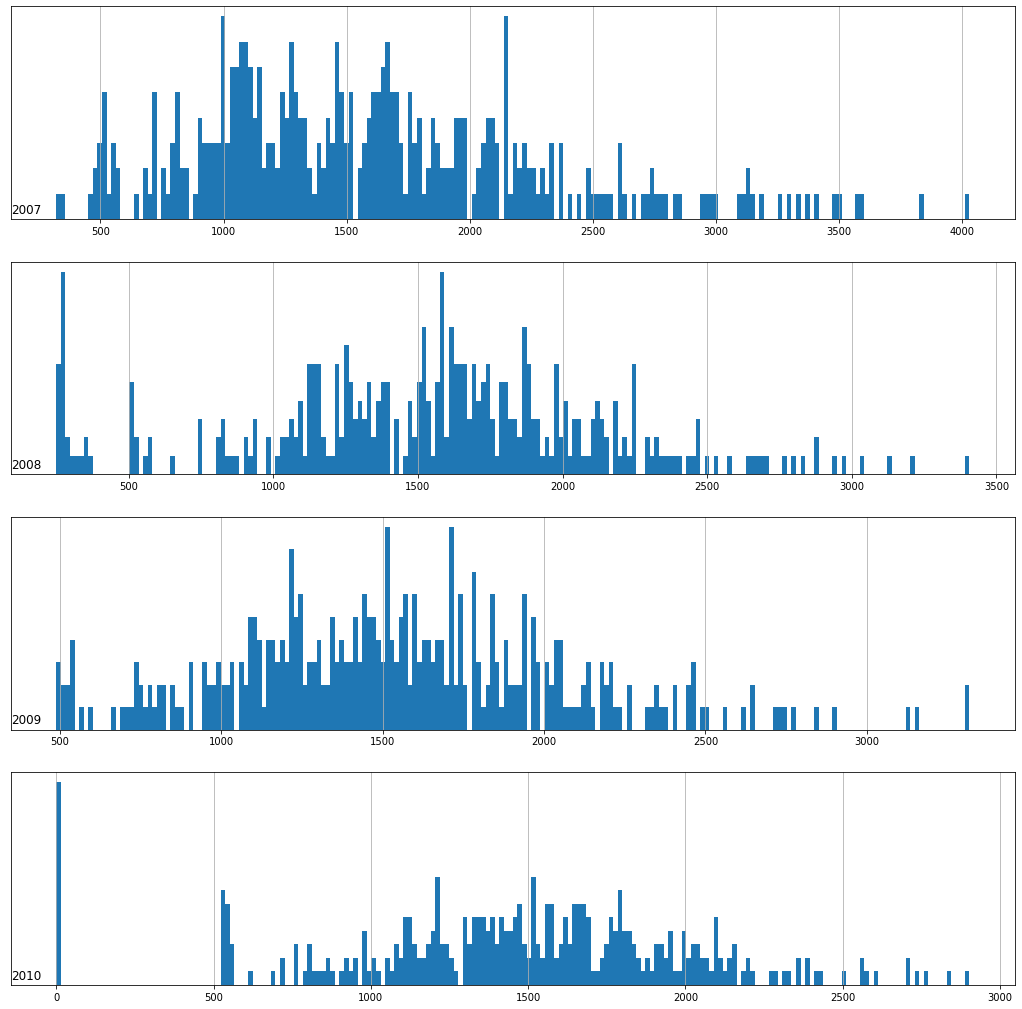

In [84]:
fig,ax=plt.subplots(figsize=(18,18))

for i in range(len(years)):
  #no.ofrows,cols,number
  plt.subplot(len(years),1,i+1)
  year=years[i]
  data[str(year)]['Global_active_power'].hist(bins=200)
  plt.title(str(year),y=0,loc='left')
  plt.yticks([])
plt.show()
fig.tight_layout()

### Histogram view for each Features

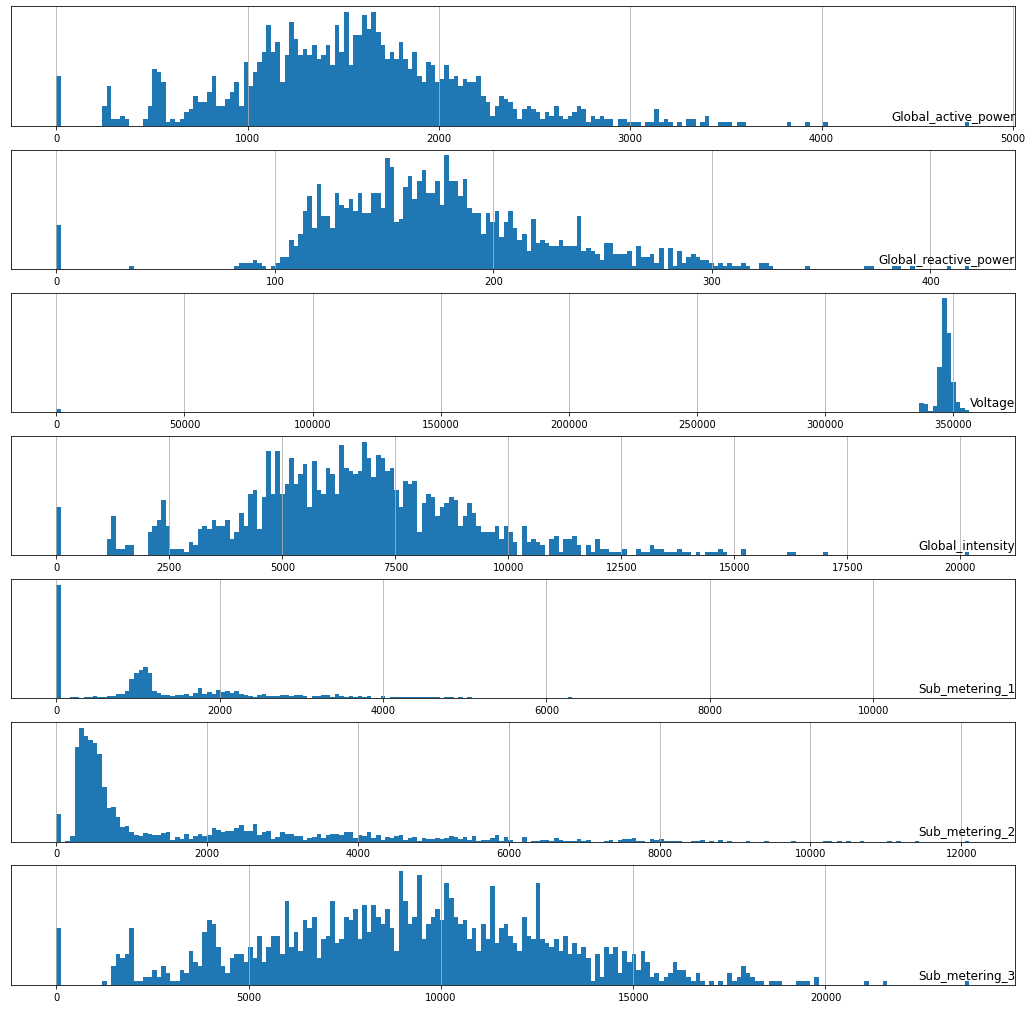

In [86]:
fig,ax=plt.subplots(figsize=(18,18))

for i in range(len(data.columns)):
  #no.ofrows,cols,number
  plt.subplot(len(data.columns),1,i+1)
  name=data.columns[i]
  data[name].hist(bins=200)
  plt.title(name,y=0,loc='right')
  plt.yticks([])
plt.show()
fig.tight_layout()

# Forecast daily consumption for next week

### with a weeks data(7days values) we need to fing the next 7 days values if x_train is from 16/12/2006 - 22/12/2006 y_train will be from 23/12/2006 to 29/12/2006


### we are going to use the data till 2009 for training and 2010 for testing

In [48]:
data_train=data.loc[:'2009-12-31',:]["Global_active_power"]

In [49]:
data_test=data["2010"]["Global_active_power"]

In [50]:
data_train

DateTime
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
                ...   
2009-12-27    2195.452
2009-12-28    2094.098
2009-12-29    2047.968
2009-12-30    2451.110
2009-12-31    2211.892
Freq: D, Name: Global_active_power, Length: 1112, dtype: float64

In [51]:
data_test

DateTime
2010-01-01    1224.252
2010-01-02    1693.778
2010-01-03    1298.728
2010-01-04    1687.440
2010-01-05    1320.158
                ...   
2010-12-07    1109.574
2010-12-08     529.698
2010-12-09    1612.092
2010-12-10    1579.692
2010-12-11    1836.822
Freq: D, Name: Global_active_power, Length: 345, dtype: float64

In [52]:
data_train.shape

(1112,)

In [53]:
data_test.shape

(345,)

## Prepare training data

In [30]:
data_train=np.array(data_train)

In [31]:


def prepareData(data):
  X,Y=[],[]
  for i in range(7,len(data_train)-7):
    X.append(data[i-7:i])
    Y.append(data[i:i+7])
  return np.array(X),np.array(Y)
  

In [32]:
X_train,Y_train=prepareData(data_train)
X_train.shape,Y_train.shape

((1098, 7), (1098, 7))

In [33]:
X_train

array([[1209.176, 3390.46 , 2203.826, ..., 2225.748, 1723.288, 2341.338],
       [3390.46 , 2203.826, 1666.194, ..., 1723.288, 2341.338, 4773.386],
       [2203.826, 1666.194, 2225.748, ..., 2341.338, 4773.386, 2550.012],
       ...,
       [1940.116, 1394.874, 1717.182, ..., 2204.334, 1144.166, 2034.966],
       [1394.874, 1717.182, 1744.706, ..., 1144.166, 2034.966, 1888.022],
       [1717.182, 1744.706, 2204.334, ..., 2034.966, 1888.022, 1455.2  ]])

In [ ]:
Y_train

array([[4773.386, 2550.012, 2743.12 , ..., 1528.76 , 2072.638, 3174.392],
       [2550.012, 2743.12 , 3934.11 , ..., 2072.638, 3174.392, 2796.108],
       [2743.12 , 3934.11 , 1528.76 , ..., 3174.392, 2796.108, 3494.196],
       ...,
       [1888.022, 1455.2  , 2905.894, ..., 2183.618, 2195.452, 2094.098],
       [1455.2  , 2905.894, 2127.648, ..., 2195.452, 2094.098, 2047.968],
       [2905.894, 2127.648, 2183.618, ..., 2094.098, 2047.968, 2451.11 ]])

In [34]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6
0,1209.176,3390.460,2203.826,1666.194,2225.748,1723.288,2341.338
1,3390.460,2203.826,1666.194,2225.748,1723.288,2341.338,4773.386
2,2203.826,1666.194,2225.748,1723.288,2341.338,4773.386,2550.012
3,1666.194,2225.748,1723.288,2341.338,4773.386,2550.012,2743.120
4,2225.748,1723.288,2341.338,4773.386,2550.012,2743.120,3934.110
...,...,...,...,...,...,...,...
1093,2138.814,1794.862,1940.116,1394.874,1717.182,1744.706,2204.334
1094,1794.862,1940.116,1394.874,1717.182,1744.706,2204.334,1144.166
1095,1940.116,1394.874,1717.182,1744.706,2204.334,1144.166,2034.966
1096,1394.874,1717.182,1744.706,2204.334,1144.166,2034.966,1888.022


## Data Standardisation

In [35]:
X_scaler=MinMaxScaler()
X_train=X_scaler.fit_transform(X_train)

In [36]:
Y_scaler=MinMaxScaler()
Y_train=Y_scaler.fit_transform(Y_train)

In [37]:
np.max(Y_train)

1.0

In [38]:
X_train.shape

(1098, 7)

In [39]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
Y_train=Y_train.reshape(Y_train.shape[0],Y_train.shape[1],1)

In [40]:
X_train.shape,Y_train.shape

((1098, 7, 1), (1098, 7, 1))

## Build the LSTM Model

In [41]:
regressor=Sequential()
regressor.add(LSTM(50,activation='relu',input_shape=X_train[0].shape))

regressor.add(Dense(7))

In [42]:
regressor.compile(loss='mse',optimizer='adam')

In [43]:
regressor.fit(X_train,Y_train,epochs=100)

Epoch 1/100
35/35 [==============================] - 2s 5ms/step - loss: 0.1131
Epoch 2/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0377
Epoch 3/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0243
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 5/100
35/35 [==============================] - 0s 6ms/step - loss: 0.0238
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 7/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0238
Epoch 8/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0237
Epoch 9/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0236
Epoch 10/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0237
Epoch 11/100
35/35 [==============================] - 0s 6ms/step - loss: 0.0237
Epoch 12/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0236
Epoch 13/100
35/35 [=================

## Preparing the test data

In [54]:
data_test=np.array(data_test)

In [56]:
X,Y=[],[]
for i in range(7,len(data_test)-7):
  X.append(data_test[i-7:i])
  Y.append(data_test[i:i+7])
  
X_test,Y_test=np.array(X),np.array(Y)
X_test.shape,Y_test.shape

((331, 7), (331, 7))

## Standardize test data

In [57]:
X_test=X_scaler.transform(X_test)
Y_test=Y_scaler.transform(Y_test)

In [59]:
X_test.shape

(331, 7)

In [60]:
X_test=X_test.reshape(331,7,1)

In [61]:
y_pred=regressor.predict(X_test)



In [63]:
y_pred.shape

(331, 7)

## Inverse Transform

In [64]:
Y_test=Y_scaler.inverse_transform(Y_test)

In [65]:
Y_test

array([[ 555.664, 1593.318, 1504.82 , ...,    0.   , 1995.796, 2116.224],
       [1593.318, 1504.82 , 1383.18 , ..., 1995.796, 2116.224, 2196.76 ],
       [1504.82 , 1383.18 ,    0.   , ..., 2116.224, 2196.76 , 2150.112],
       ...,
       [1892.998, 1645.424, 1439.426, ..., 1973.382, 1109.574,  529.698],
       [1645.424, 1439.426, 2035.418, ..., 1109.574,  529.698, 1612.092],
       [1439.426, 2035.418, 1973.382, ...,  529.698, 1612.092, 1579.692]])

In [67]:
y_pred=Y_scaler.inverse_transform(y_pred)

In [68]:
y_pred

array([[1515.9186 , 1496.88   , 1479.8429 , ..., 1545.8839 , 1536.8914 ,
        1587.7522 ],
       [1113.9689 , 1276.8136 , 1350.5529 , ..., 1461.6622 , 1478.7765 ,
        1509.8492 ],
       [1538.6195 , 1507.8156 , 1495.4393 , ..., 1496.8003 , 1473.3479 ,
        1540.4517 ],
       ...,
       [1193.3127 , 1075.157  ,  980.74475, ...,  875.1734 ,  773.55585,
         947.0401 ],
       [1530.7007 , 1356.493  , 1186.0039 , ...,  983.0266 ,  901.19006,
        1099.2177 ],
       [1604.1215 , 1381.4628 , 1223.493  , ..., 1032.5989 , 1000.0703 ,
        1190.0807 ]], dtype=float32)

In [71]:
def evaluate_model(y_true,y_pred):
  scores=[]

  ## Calculate rmse for each column(each day like monday,tuesday)

  for i in range(y_true.shape[1]):
    mse=mean_squared_error(y_true[:,i],y_pred[:,i])
    rmse=np.sqrt(mse)
    scores.append(rmse)

  ## Calculate the difference between all the values
  total_score=0
  for row in range(y_true.shape[0]):
    for col in range(y_true.shape[1]):
      total_score=total_score+(y_true[row,col]-y_pred[row,col])**2
  # total score divided by total no of elements
  total_score=np.sqrt(total_score/(y_true.shape[0]*y_true.shape[1]))

  return total_score,scores


In [72]:
evaluate_model(Y_test,y_pred)

(582.1463969109684,
 [592.1976553107115,
  595.7220420064165,
  574.6581056252062,
  571.7722848042159,
  580.2886251757714,
  576.4143728577282,
  583.5531475288478])

In [73]:
# to compare this we must find the std dev of a column if our rmse of a column is less than the std.dev of a column then ours is a good model

col1=np.std(Y_test[0])

In [74]:
col1

710.0253857243853

In [75]:
col2=np.std(Y_test[1])

In [76]:
col2

693.9921959451827

In [77]:
# our model is good since our rmse values is less than the std.dev